# 04. Networks

In this exercise, we will explore networks and distance. We will start by using an abstract network of points and lines to illustrate some concepts, and then move on to using real-world data to identify proximate objects based on network distance.

## Import libraries

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, Polygon
import pandas as pd
import requests
import networkx as nx
import osmnx as ox
import h3
import libpysal as lps

In [80]:
# we'll begin by borrowing the plotting helper function we created in the geoprocessing notebook for use here.
# oftentimes when writing functions that we want to come back to, we can create a new python file (such as utils.py)
# and import functions from there.
def set_axis_off():
    """
    Set the default matplotlib settings to turn off axes and ticks.
    This function modifies the global matplotlib configuration to hide axes and ticks
    for all plots created after this function is called.
    """
    # set axis off by default
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.axisbelow"] = False
    plt.rcParams["axes.spines.left"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.bottom"] = False

    # set tick params off by default
    plt.rcParams["xtick.bottom"] = False
    plt.rcParams["xtick.top"] = False
    plt.rcParams["xtick.labelbottom"] = False
    plt.rcParams["xtick.labeltop"] = False
    plt.rcParams["ytick.left"] = False
    plt.rcParams["ytick.right"] = False
    plt.rcParams["ytick.labelleft"] = False
    plt.rcParams["ytick.labelright"] = False

In [82]:
set_axis_off()

To begin, we will find the approximate bounding box of NYC.

In [2]:
# bounding box of nyc
bbox = (-74.3, 40.5, -73.7, 40.9)

## Create random network

We'll begin by creating a dataframe of 100 random points. As we can see below, we are using `numpy` to generate random numbers, along with geopandas' `points_from_xy()` to create a geodataframe from these points. We are using the bounds of NYC to make sure that the network approximately covers the city.

In [81]:
# create a geodataframe of 100 random points
np.random.seed(0)
n = 100
df = pd.DataFrame(
    {
        "geometry": gpd.points_from_xy(
            np.random.uniform(-74.3, -73.7, n),
            np.random.uniform(40.5, 40.9, n),
        ),
    }
)

And here we cast the dataframe as a geodataframe and set its CRS.

In [4]:
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326")

As we can see from our initial plot, we have a mass of 100 randomly distributed points. At this stage, this is meaningless!

<Axes: >

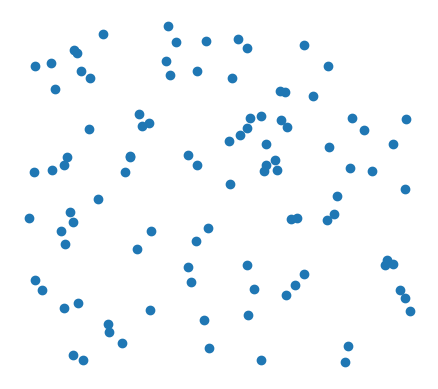

In [83]:
gdf.plot()

Since we are creating a network (instead of analyzing an already existing one), let's connect each node to its five nearest neighbors (measured based on straight-line or *Euclidean* distance). We'll use geopandas' `distance` method to calculate the distance between each pair of points, and then use that to create a list of edges. There are many ways to calculate distance like this, some of which are more appropriate for working with a greater volume of data (`scipy`'s `KDTree` operations chief among them).

We can also ignore the warning about the geographic CRS as well given our use case and scale, but do keep in mind that projection-related considerations are extremely important when calculating distances.

In [85]:
# find five nearest neighbors for each point, not including itself
k = 5
neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(
    axis=1
)[:, 1 : k + 1]

# join neighbors to original dataframe
gdf["neighbors"] = neighbors.tolist()

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_65798/2007509322.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighbors = gdf.geometry.apply(lambda x: gdf.geometry.distance(x)).values.argsort(


Now if we inspect our dataframe, we see that we have an additional column, `neighbors`, which contains the row index number of the five nearest points to that row.

In [87]:
gdf.head()

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."


Based on that information, we can now draw *lines* (or network *edges*) between each point and its nearest neighbors. We can use the following function to create an array of lines between a point and it's neighbors. 

Let's consider the component parts of the function:
- `lines = []`: we create an empty array to store line geometry in
- `for i, neighbor in enumerage(r.neighbors)`: we set up a `for` loop to iterate through each row's list of point indexes
- `lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))`: we create a new `LineString` geometry with two points: the starting point at the input row `r.geometry`, and ending at the looked up neighbor's geometry `gdf.loc[neighbor].geometry`. The `.loc[neighbor]` allows us to find the row that matches based on the neighbor `id`, and then we access its `geometry` property
- `return MultiLineString(lines)`: we combine each of the line geometries in the `lines` array into one complex `MultiLineString`, which is what it sounds like (a combination of `LineStrings`).

In [9]:
def create_lines(r):
    lines = []
    for i, neighbor in enumerate(r.neighbors):
        lines.append(LineString([r.geometry, gdf.loc[neighbor].geometry]))
    return MultiLineString(lines)

We can then apply the function to each row (`axis=1`). Keep in mind that when executing a function via `apply()`, the row (or column) input is implied and is the default input `r` in the function.

In [88]:
gdf["line_geometry"] = gdf.apply(create_lines, axis=1)

If we inspect our dataframe again, we'll see a new column `line_geometry` which represents the edges between each point and its five nearest neighbors.

In [90]:
gdf.head()

,geometry,neighbors,line_geometry
0,POINT (-73.97071 40.77113),"[12, 28, 88, 2, 37]","MULTILINESTRING ((-73.97071 40.77113, -73.9591..."
1,POINT (-73.87089 40.60800),"[83, 91, 42, 39, 31]","MULTILINESTRING ((-73.87089 40.60800, -73.8845..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
3,POINT (-73.97307 40.88488),"[84, 11, 22, 51, 56]","MULTILINESTRING ((-73.97307 40.88488, -73.9600..."
4,POINT (-74.04581 40.59950),"[29, 41, 32, 58, 80]","MULTILINESTRING ((-74.04581 40.59950, -74.0512..."


We can create a new geodataframe based on this edges geometry and plot it- now we have a connected network of points and lines!

In [91]:
lines_gdf = gpd.GeoDataFrame(
    gdf[["line_geometry"]], geometry="line_geometry", crs="EPSG:4326"
)

<Axes: >

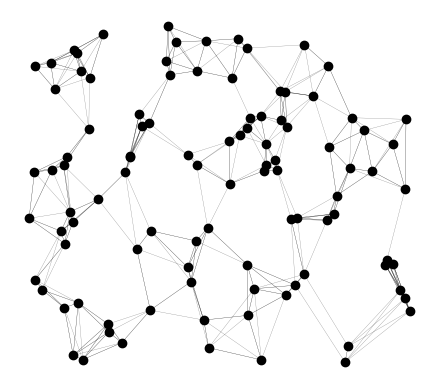

In [94]:
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="black")

# optionally save the figure to file
# plt.savefig("lines.pdf", bbox_inches="tight", pad_inches=0)

### Saving our datasets

You may optionally want to save these nodes and edges to file to inspect in QGIS or another software. To do so, we use the `to_file()` function to save out as GeoJSON files


In [95]:
gdf["geometry"].to_file("nodes.geojson", driver="GeoJSON")
gdf["line_geometry"].to_file("edges.geojson", driver="GeoJSON")

In [96]:
gdf.sample(10)

,geometry,neighbors,line_geometry
91,POINT (-73.89955 40.58394),"[83, 1, 96, 50, 33]","MULTILINESTRING ((-73.89955 40.58394, -73.8845..."
29,POINT (-74.05120 40.61603),"[4, 41, 58, 32, 90]","MULTILINESTRING ((-74.05120 40.61603, -74.0458..."
2,POINT (-73.93834 40.79408),"[88, 12, 62, 37, 0]","MULTILINESTRING ((-73.93834 40.79408, -73.9544..."
50,POINT (-73.95788 40.55978),"[96, 73, 33, 91, 32]","MULTILINESTRING ((-73.95788 40.55978, -73.9480..."
44,POINT (-73.89994 40.82248),"[56, 62, 45, 74, 2]","MULTILINESTRING ((-73.89994 40.82248, -73.9081..."
78,POINT (-74.12232 40.78177),"[48, 94, 30, 85, 57]","MULTILINESTRING ((-74.12232 40.78177, -74.1107..."
33,POINT (-73.95894 40.61931),"[96, 50, 91, 58, 83]","MULTILINESTRING ((-73.95894 40.61931, -73.9480..."
65,POINT (-74.07876 40.84232),"[40, 9, 51, 49, 48]","MULTILINESTRING ((-74.07876 40.84232, -74.0843..."
75,POINT (-74.27649 40.58957),"[97, 69, 92, 67, 15]","MULTILINESTRING ((-74.27649 40.58957, -74.2879..."
45,POINT (-73.89762 40.78156),"[62, 37, 44, 2, 56]","MULTILINESTRING ((-73.89762 40.78156, -73.9062..."


Let's plot the nearest neighbors and connecting edges for a single point. Below, we take a random point `s` and then highlight it in blue, and connect it to its five nearest neighbors in orange. Keep in mind that every time you rerun the following cell, a new sampled point will be chosen.

<Axes: >

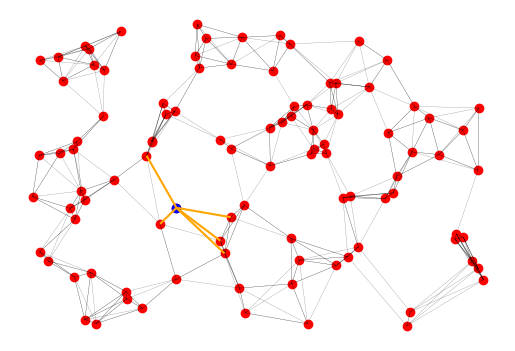

In [97]:
# plot the lines for a single point
s = gdf.sample()
ax = lines_gdf.plot(color="black", alpha=0.5, linewidth=0.2)
gdf.plot(ax=ax, color="red")

s.plot(ax=ax, color="blue")
gpd.GeoSeries(s.line_geometry).plot(ax=plt.gca(), color="orange")

## Apply to a real-world example


The toy problem above was a fine way to explore this concept, so now let's apply it to real-world networks. We will use an API endpoint hosted through NYCOpenData to find restaurants in Morningside Heights.

There are a couple of things to keep in mind about the following API request. First is the request itself: we use the popular `requests` library to perform a `GET` request (there are many types of requests, read more [here](https://requests.readthedocs.io/en/latest/user/quickstart/#make-a-request)) on the API endpoint listed at the resource URL. 


We can see on the open data portal's website that each dataset has an `Actions` dropdown, and within that there's an `API` option:

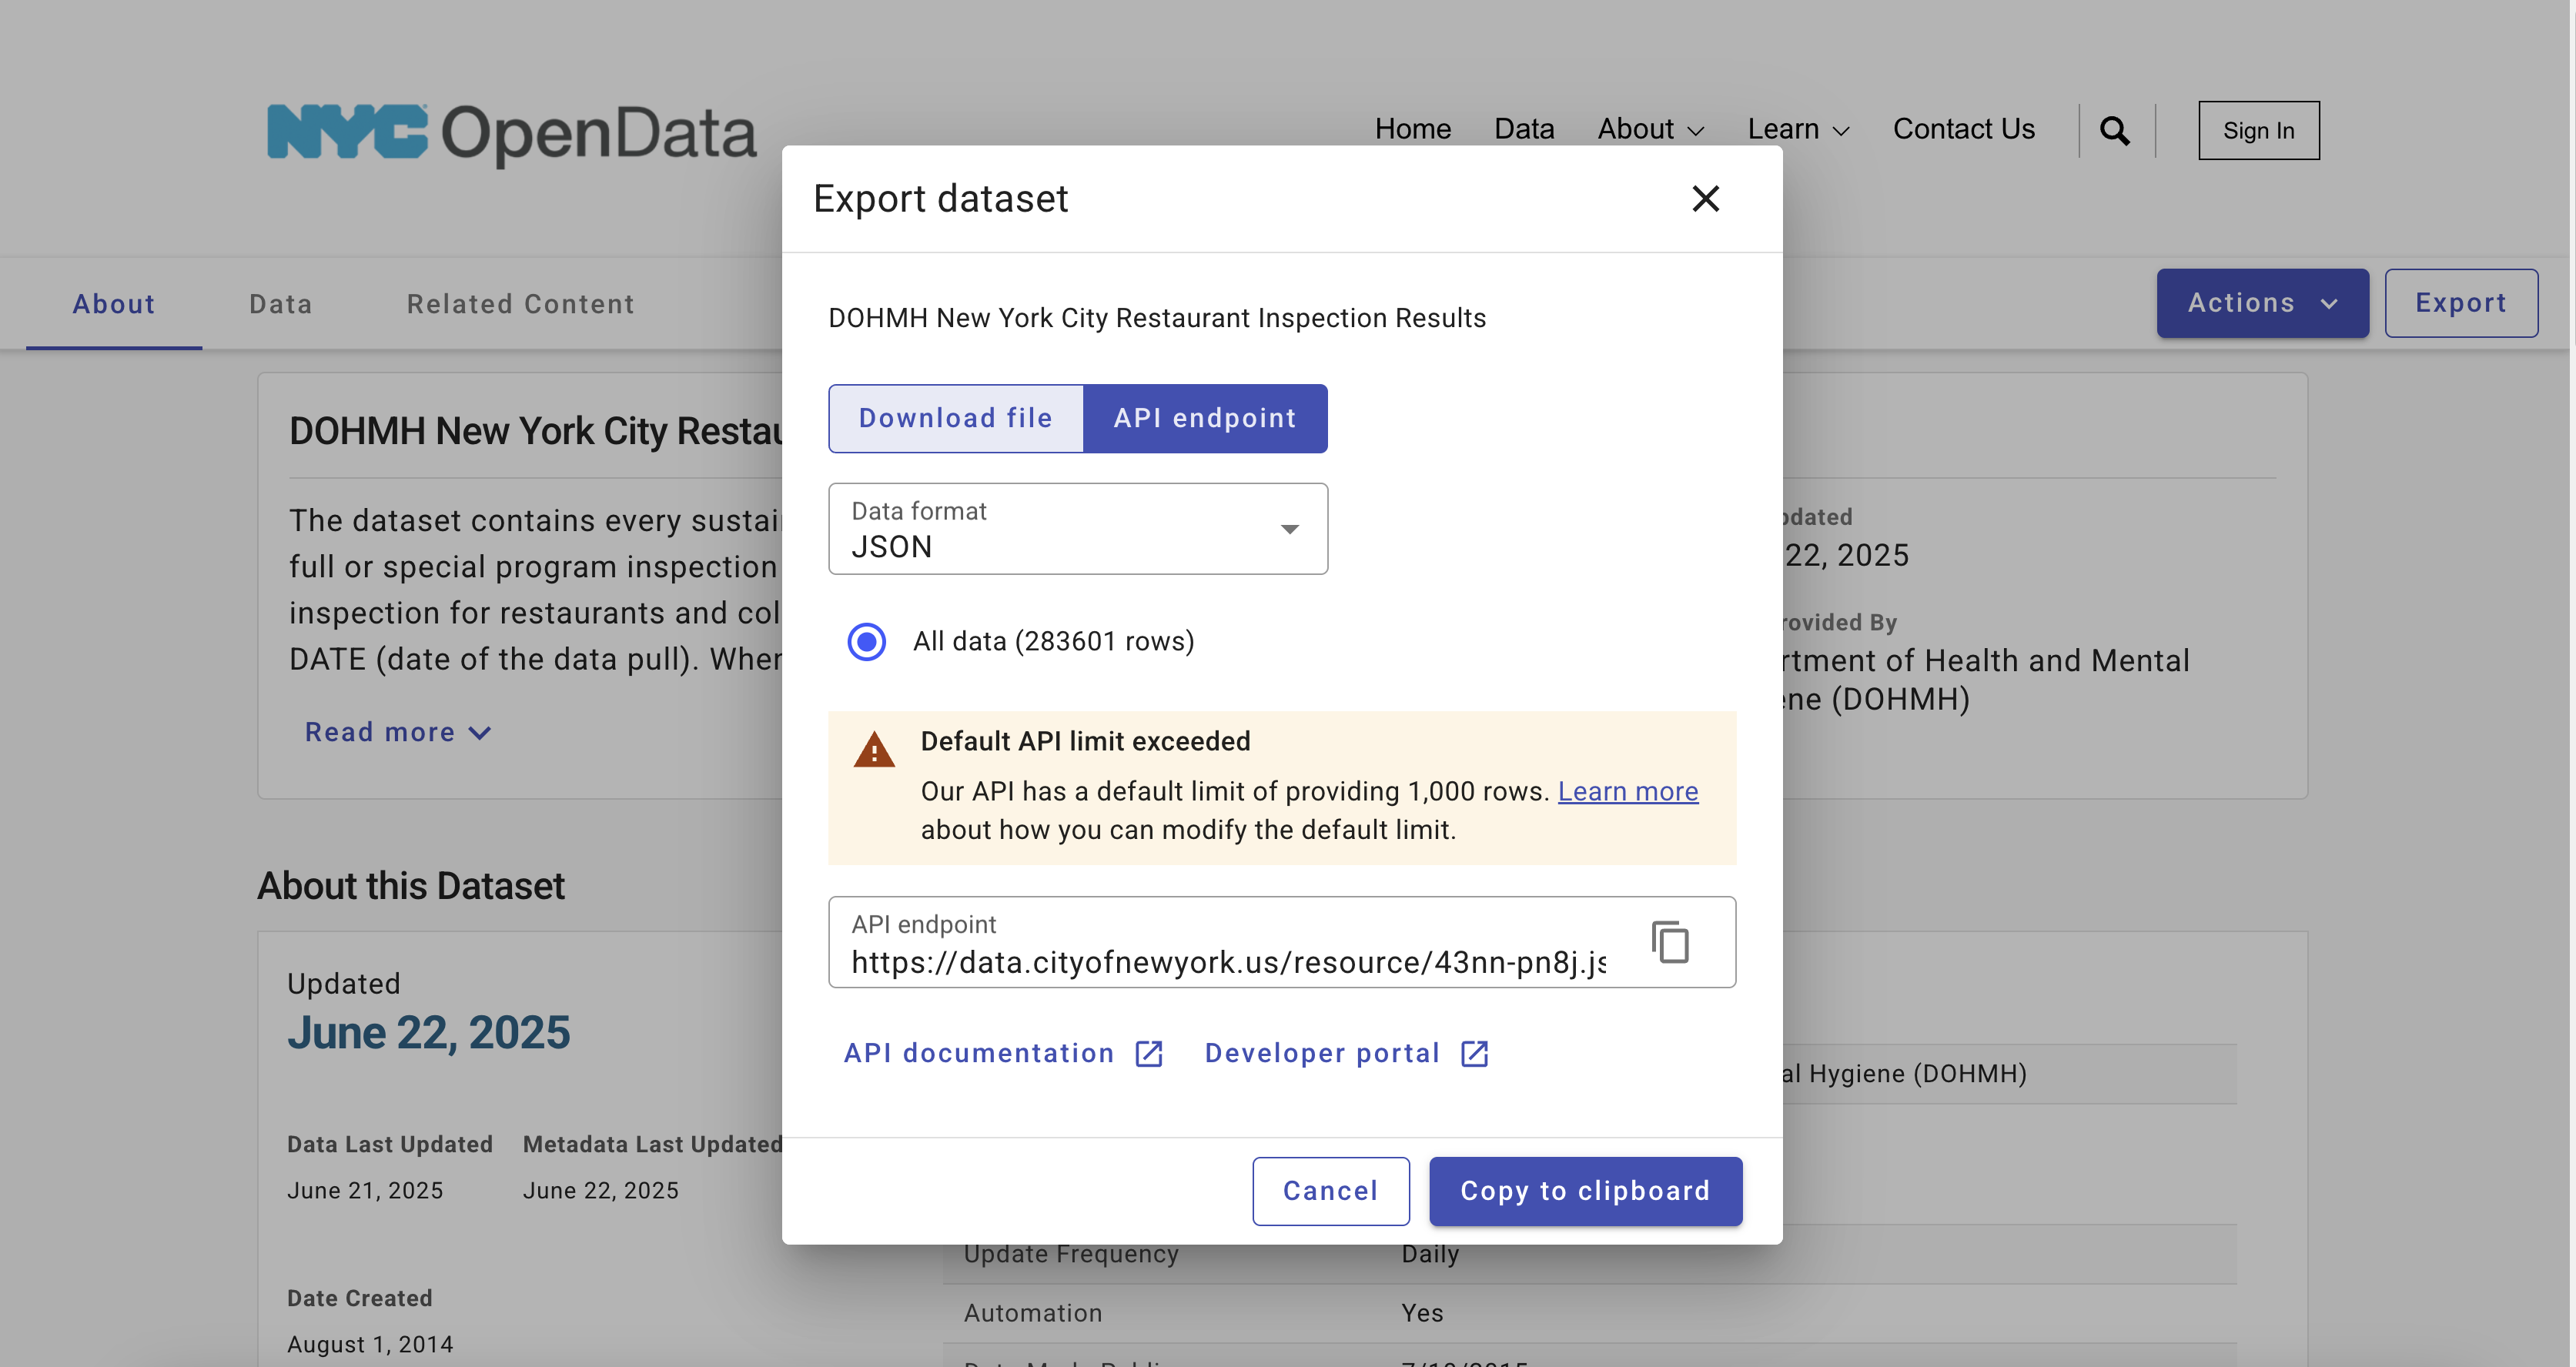

The API endpoint given there is the basis of the URL below. We are adding some additional query filters to focus the response items and reduce the total number of responses (as you can see in the screenshot above, there are over 280,000 results).

We add `?NTA=MN09&$limit=2000`, which signifies that we only want resulst where the `NTA` field equals `MN09` (i.e. Morningside Heights) and we `limit` the number of responses to `2000`. You can learn more about formatting SODA queries [here](https://dev.socrata.com/consumers/getting-started.html)

## get restaurants in Morningside Heights


If a query is successful, it will return a result that starts with `2**`, such as `200`. Error codes are reserved for `4**` and `5**`. We can make this most basic request first to confirm that our query is properly formatted:

In [18]:
requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
)

<Response [200]>

What we really want, however, is the `json` associated with the response. We can create a new variable and set it to equal the response json payload:

In [99]:
mh_restaurants = requests.get(
    "https://data.cityofnewyork.us/resource/43nn-pn8j.json?NTA=MN09&$limit=2000"
).json()

If we print the results, we see we have an array of objects (up to 2000) that represents the restaurants in `MN09`. If you scan through, you'll see attributes like street, building number, cuisine_description, and restaurant scores. 

In [102]:
mh_restaurants

[{'camis': '41561808',
  'dba': 'FALAFEL ON BROADWAY',
  'boro': 'Manhattan',
  'building': '3151',
  'street': 'BROADWAY',
  'zipcode': '10027',
  'phone': '2122222300',
  'cuisine_description': 'Middle Eastern',
  'inspection_date': '2024-01-11T00:00:00.000',
  'action': 'Violations were cited in the following area(s).',
  'violation_code': '10F',
  'violation_description': 'Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.',
  'critical_flag': 'Not Critical',
  'score': '13',
  'grade': 'A',
  'grade_date': '2024-01-11T00:00:00.000',
  'record_date': '2025-06-21T06:00:14.000',
  'inspection_type': 'Cycle Inspection / Initial Inspection',
  'latitude': '40.814315191017',
  'longitude': '-73.959299573149',
  'community_board': '109',
  'council_district': '07',
  'census_tract': '021100',
  'bin': '1059853',
  'bbl': '101

For these to be useful to us, let's cast the array as a geodataframe:

In [103]:
mh_restaurants = gpd.GeoDataFrame(
    mh_restaurants,
    geometry=gpd.points_from_xy(
        [float(x["longitude"]) for x in mh_restaurants],
        [float(x["latitude"]) for x in mh_restaurants],
    ),
)

In [104]:
mh_restaurants.fillna("na", inplace=True)

Now we can see that we have a dataframe with a number of columns, including a geometry column, that we can use to perform calculations on.

In [23]:
mh_restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'bbl',
       'nta', 'geometry'],
      dtype='object')

We can also drop duplicate records (based on the `camis` unique restaurant id):

In [105]:
mh_restaurants.drop_duplicates(subset="camis", inplace=True)

Let's inspect the restaurant grades:

In [107]:
mh_restaurants.grade.value_counts()

grade
A     78
na    75
N     10
Z      5
B      5
C      3
Name: count, dtype: int64

Additionally, let's check out the type of food served at each restaurant:

In [26]:
mh_restaurants.cuisine_description.value_counts()

cuisine_description
American                          29
Coffee/Tea                        22
na                                16
Chinese                           11
Pizza                              8
Mexican                            7
Italian                            7
Japanese                           6
Hamburgers                         5
Asian/Asian Fusion                 4
French                             4
Juice, Smoothies, Fruit Salads     4
Other                              4
Sandwiches/Salads/Mixed Buffet     3
Fusion                             3
Ethiopian                          3
Frozen Desserts                    3
Indian                             3
Thai                               2
Mediterranean                      2
Sandwiches                         2
Hawaiian                           2
Donuts                             2
Salads                             2
Middle Eastern                     2
Tex-Mex                            2
Chicken           

## Build a graph to allow us to search


Now that we have a geodataframe of restaurants, let's create a network based on the street grid of the neighborhood. To do so, we'll use the total geographic bounds of our restaurants dataframe to request a network from the `OSMnx` module. `OSMnx` is built on top of the `Networkx` library, and makes it easy for users to access information from `OpenStreetMap` for use in network analysis.

In [108]:
mh_bbox = mh_restaurants.total_bounds

In [109]:
mh_bbox

array([-73.96804436,  40.79882472, -73.9527956 ,  40.81596727])

Like the name implies, we can build a network graph from the bbox above using the `graph_from_bbox()` function. We can specify that we are interested in a `walk` type network (i.e. pedestrian paths and sidewalks) using the `network_type` parameter (vs `driving` or `all` for example).

Note too that the order of coordinates returned from the `total_bounds` property does not match the order that `OSMnx` expects it, so we have to reorder them via the `bbox` parameter.

In [111]:
mh_network = ox.graph_from_bbox(
    bbox=[mh_bbox[3], mh_bbox[1], mh_bbox[2], mh_bbox[0]], network_type="walk"
)

We can confirm that the result is a `networkx` multidirectional (`MultiDiGraph`) graph object:

In [112]:
mh_network

...and we can extract the nodes and edges of that network out as geodataframes:

In [113]:
mh_net_nodes, mh_net_edges = ox.graph_to_gdfs(mh_network)

By inspecting the results, we can see that each row is a street network segment with a number of properties, all derived from OSM data.

In [114]:
mh_net_edges.head()

osmid               name    highway  oneway  \
u        v           key                                                    
42421737 10171363583 0    195743201  West 106th Street  secondary   False   
         10171363584 0    420625562    Columbus Avenue    primary   False   
         10171363585 0    420625563    Columbus Avenue    primary   False   
         10171363586 0    420625567  West 106th Street  secondary   False   
42421741 10166004078 0    196116970   Amsterdam Avenue    primary   False   

                         reversed  length lanes maxspeed  \
u        v           key                                   
42421737 10171363583 0       True  12.354   NaN      NaN   
         10171363584 0       True  12.763     4   25 mph   
         10171363585 0      False  11.700     3   25 mph   
         10171363586 0       True  12.512     2      NaN   
42421741 10166004078 0      False  12.881     3      NaN   

                                                                   geometry  \
u        v           key                                                      
42421737 10171363583 0    LINESTRING (-73.96287 40.79924, -73.96275 40.7...   
         10171363584 0    LINESTRING (-73.96287 40.79924, -73.96280 40.7...   
         10171363585 0    LINESTRING (-73.96287 40.79924, -73.96294 40.7...   
         10171363586 0    LINESTRING (-73.96287 40.79924, -73.96300 40.7...   
42421741 10166004078 0    LINESTRING (-73.96569 40.80043, -73.96562 40.8...   

                         junction access bridge tunnel width service  
u        v           key                                              
42421737 10171363583 0        NaN    NaN    NaN    NaN   NaN     NaN  
         10171363584 0        NaN    NaN    NaN    NaN   NaN     NaN  
         10171363585 0        NaN    NaN    NaN    NaN   NaN     NaN  
         10171363586 0        NaN    NaN    NaN    NaN   NaN     NaN  
42421741 10166004078 0        NaN    NaN    NaN    NaN   NaN     NaN

Let's take a look at the output- we can see a network of nodes and edges that represent the Morningside Heights area. Note that unlike our toy example above, network edges here can have corners and curves and are not just individual line segments.

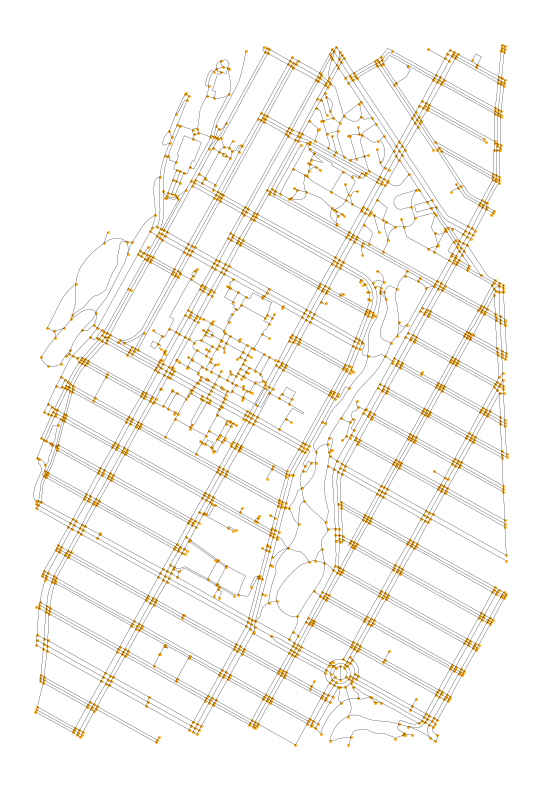

In [ ]:
ax = mh_net_edges.plot(color="black", linewidth=0.1, figsize=(10, 10))
mh_net_nodes.plot(ax=ax, color="orange", markersize=1).set_axis_off()

Great - now that we have a network and locations to traverse, let's use a starting point based on where we are on campus:

In [117]:
fayerweather = Point(-73.9603477, 40.8082408)

### Get directions to a random point


First we need to associate our starting point and target points to our networks. We begin by finding the nearest network nodes between an input coordinate and the network, for both our origin and a randomly selected restaurant.

In [122]:
orig = ox.distance.nearest_nodes(mh_network, fayerweather.x, fayerweather.y)
sample = mh_restaurants.sample()
dest = ox.distance.nearest_nodes(mh_network, sample.geometry.x, sample.geometry.y)[0]

The above functions return the indices of the nearest network nodes:

In [124]:
orig, dest

(2340960642, 10166004077)

Now that we have *network* positions, we can traverse the network to find the shortest path between each point. To do so, we'll use the `shortest_path()` function, and specify our `weight` as the `length` between start and end points. There are a number of options for weight, including the number of segments that need to be traversed, or a custom input you specify.

OSMnx also has special helper functions to plot routes, which we'll use to plot the network and path between points.

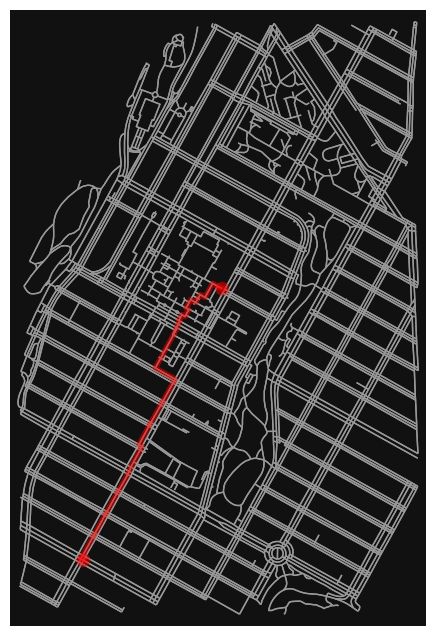

In [125]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(mh_network, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(mh_network, route, node_size=0)

If we inspect the `route` on its own, we'll see an array of node ids that are ordered based on the shortest path that is generated. 

In [127]:
route

[2340960642,
 2340960647,
 2340960652,
 2340960633,
 2340960637,
 2340960632,
 2340960619,
 2340960621,
 2340960628,
 3907629293,
 2308955266,
 2308955236,
 2340960582,
 2308955275,
 2308955246,
 2308955237,
 2308955273,
 2308955255,
 2308955234,
 9484229174,
 5924124668,
 3579426865,
 627905340,
 5924124670,
 10171340197,
 10168667115,
 7326861789,
 10168667114,
 11777607957,
 7326861889,
 11777607959,
 6814307793,
 6814307795,
 6814307788,
 10170704048,
 6814307791,
 42442571,
 4717512348,
 7618358575,
 6814307785,
 42442569,
 10170893932,
 10170893924,
 42442567,
 10170893928,
 10165989507,
 42442565,
 10165989508,
 10166004026,
 42432756,
 10166004025,
 10166004078,
 42421741,
 10166004077]

That's not super useful to us- thankfully OSMnx makes it easy to convert the route to a geodataframe for use elsewhere. We can also use some basic math to convert the path from meters to miles to put things in perspective.

In [129]:
edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

# convert meters to miles
sum(edge_lengths) / 1609.34

0.7286067580498837

In [130]:
mh_pizza = mh_restaurants[mh_restaurants.cuisine_description == "Pizza"]

<Axes: >

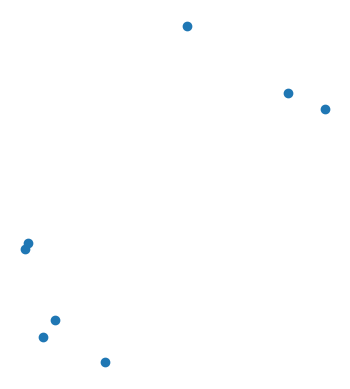

In [131]:
mh_pizza.plot()

In [43]:
def distance_from_point(row, origin):
    """
    Returns the distance in miles and the geometry of the shortest path between a point and a destination.

    Parameters:
    row (pd.Series): A row from a pandas DataFrame.
    origin (int): The origin node in the network.
    """

    dest = ox.distance.nearest_nodes(mh_network, row.geometry.x, row.geometry.y)  # [0]
    route = ox.shortest_path(mh_network, origin, dest, weight="length")
    edge_lengths = ox.routing.route_to_gdf(mh_network, route)["length"]

    route_geom = ox.routing.route_to_gdf(mh_network, route)
    route_geom = route_geom.geometry.unary_union

    return {"distance": sum(edge_lengths) / 1609.34, "route_geom": route_geom}

In [44]:
mh_pizza["distance_from_avery"] = mh_pizza.apply(
    distance_from_point, origin=orig, axis=1
)

/Users/marioag/opt/anaconda3/envs/cdp/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [45]:
mh_pizza["distance_from_avery"]

15     {'distance': 0.7294462326170976, 'route_geom':...
16     {'distance': 0.4293598618067033, 'route_geom':...
24     {'distance': 0.6361477375818659, 'route_geom':...
34     {'distance': 0.5982353014279147, 'route_geom':...
49     {'distance': 0.5856829507748518, 'route_geom':...
95     {'distance': 0.6579144245467088, 'route_geom':...
139    {'distance': 0.4293598618067033, 'route_geom':...
310    {'distance': 0.7467036176320727, 'route_geom':...
Name: distance_from_avery, dtype: object

In [46]:
# explode the dictionary into separate columns
mh_pizza = pd.concat(
    [
        mh_pizza.drop(["distance_from_avery"], axis=1),
        mh_pizza["distance_from_avery"].apply(pd.Series),
    ],
    axis=1,
)

In [47]:
mh_pizza

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,longitude,community_board,council_district,census_tract,bin,bbl,nta,geometry,distance,route_geom
15,50131886,iPizza NY,Manhattan,351,WEST 125 STREET,10027,9172658973,Pizza,2024-09-19T00:00:00.000,Establishment Closed by DOHMH. Violations were...,...,-73.952795602284,109,09,020901,1059309,1019520011,MN09,POINT (-73.95280 40.81086),0.729446,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
16,50066109,KORONET PIZZA,Manhattan,2848,BROADWAY,10025,2122221566,Pizza,2022-04-04T00:00:00.000,Establishment Closed by DOHMH. Violations were...,...,-73.966410664204,109,07,019900,1056917,1018820063,MN09,POINT (-73.96641 40.80454),0.429360,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
24,41012973,MAMA'S PIZZERIA,Manhattan,941,AMSTERDAM AVENUE,10025,2125319797,Pizza,2023-04-06T00:00:00.000,Violations were cited in the following area(s).,...,-73.965614448432,107,07,019300,1055948,1018610001,MN09,POINT (-73.96561 40.80055),0.636148,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
34,50107497,TRUFA PIZZERIA,Manhattan,3161,BROADWAY,10027,9172386330,Pizza,2024-04-30T00:00:00.000,Violations were cited in the following area(s).,...,-73.959079013484,109,07,021100,1082765,1019930088,MN09,POINT (-73.95908 40.81462),0.598235,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
49,50046844,DOMINO'S,Manhattan,965,AMSTERDAM AVENUE,10025,2122222000,Pizza,2022-04-05T00:00:00.000,Violations were cited in the following area(s).,...,-73.965065043605,107,07,019300,1055985,1018620003,MN09,POINT (-73.96507 40.80129),0.585683,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
95,40605511,DOMINO'S,Manhattan,409,WEST 125 STREET,10027,2122803200,Pizza,2024-02-26T00:00:00.000,Violations were cited in the following area(s).,...,-73.954511033458,109,07,020901,1059550,1019660066,MN09,POINT (-73.95451 40.81159),0.657914,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
139,40388419,FAMOUS FAMIGLIA PIZZERIA,Manhattan,2859,BROADWAY,10025,2128651234,Pizza,2022-03-09T00:00:00.000,Violations were cited in the following area(s).,...,-73.966258832618,109,07,019900,1075440,1018947501,MN09,POINT (-73.96626 40.80478),0.429360,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."
310,50134260,PIZZA HUT,Manhattan,940,COLUMBUS AVENUE,10025,4692840850,Pizza,2025-06-09T00:00:00.000,Violations were cited in the following area(s).,...,-73.962765289762,107,07,019300,1055966,1018610029,MN09,POINT (-73.96277 40.79939),0.746704,"MULTILINESTRING ((-73.9613745 40.8077893, -73...."


In [48]:
mh_pizza_routes = gpd.GeoDataFrame(mh_pizza, geometry="route_geom", crs="EPSG:4326")

Text(0.5, 1.0, 'Distance from Buell Hall to \n Morningside Heights Pizza Restaurants')

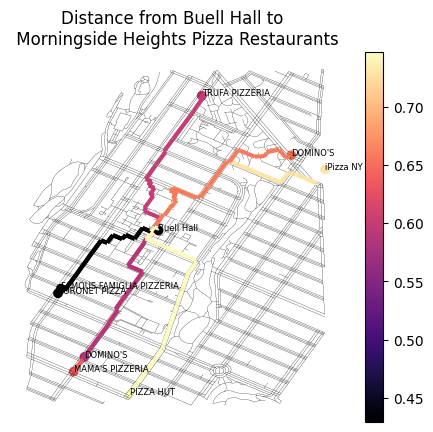

In [49]:
ax = gpd.GeoSeries(buell_hall).plot(color="black")
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)
mh_pizza_routes.plot(column="distance", cmap="magma", ax=ax, linewidth=3)
mh_pizza.plot(column="distance", cmap="magma", legend=True, ax=ax).set_axis_off()


# label each point
for x, y, label in zip(mh_pizza.geometry.x, mh_pizza.geometry.y, mh_pizza.dba):
    ax.text(x, y, label, fontsize=6)
ax.text(buell_hall.x, buell_hall.y, "Buell Hall", fontsize=6)

# title
plt.title("Distance from Buell Hall to \n Morningside Heights Pizza Restaurants")

In [50]:
mh_pizza[["dba", "distance"]].sort_values("distance")

,dba,distance
16,KORONET PIZZA,0.429360
139,FAMOUS FAMIGLIA PIZZERIA,0.429360
49,DOMINO'S,0.585683
34,TRUFA PIZZERIA,0.598235
24,MAMA'S PIZZERIA,0.636148
95,DOMINO'S,0.657914
15,iPizza NY,0.729446
310,PIZZA HUT,0.746704


<Axes: >

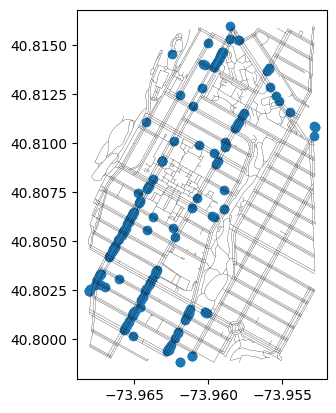

In [51]:
ax = mh_restaurants.plot()
mh_net_edges.plot(ax=ax, color="black", linewidth=0.1)

In [52]:
# use H3 grid to create a hexagon around the restaurants
# count the number of restaurants in each hexagon
# use pysal to get adjacency between hexagons
# build new network with hexagons as nodes and their adjacency as edges
# use networkx to find the shortest path between hexagons

# get the H3 hexagons

In [53]:
mh_net_nodes

74 - 76, 88 - 98

(-2, -10)

In [54]:
mh_net_nodes["h3"] = mh_net_nodes.apply(
    lambda x: h3.geo_to_h3(x.geometry.centroid.y, x.geometry.centroid.x, 9), axis=1
)

In [55]:
mh_net_nodes["h3"]

osmid
42421737       892a10088b3ffff
42421741       892a1008887ffff
42421745       892a100888fffff
42421852       892a1008c33ffff
42421857       892a1008c07ffff
                    ...       
12818423593    892a1008d4bffff
12818423594    892a1008d4bffff
12818423614    892a1008d4bffff
12818423615    892a1008d4bffff
12829214037    892a1008d43ffff
Name: h3, Length: 2055, dtype: object

In [56]:
# create hexagons for AOI
mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(
    lambda x: (h3.h3_to_geo_boundary(x))
)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_65798/2385662124.py:2: UserWarning: Geometry column does not contain geometry.
  mh_net_nodes["geometry"] = mh_net_nodes["h3"].apply(


In [57]:
mh_net_nodes["geometry"]

osmid
42421737       ((40.79992952883273, -73.9619793563826), (40.7...
42421741       ((40.80251489146534, -73.96422198910369), (40....
42421745       ((40.80240003265268, -73.96850268201203), (40....
42421852       ((40.8133159556837, -73.95606838702638), (40.8...
42421857       ((40.8159018703086, -73.95831132341029), (40.8...
                                     ...                        
12818423593    ((40.8026295918606, -73.95994128961736), (40.8...
12818423594    ((40.8026295918606, -73.95994128961736), (40.8...
12818423614    ((40.8026295918606, -73.95994128961736), (40.8...
12818423615    ((40.8026295918606, -73.95994128961736), (40.8...
12829214037    ((40.80274413383744, -73.95566058360083), (40....
Name: geometry, Length: 2055, dtype: object

In [58]:
# flip order of coordinates for each tuple
mh_net_nodes["geometry"] = mh_net_nodes["geometry"].apply(
    lambda x: Polygon([(y, x) for x, y in x])
)

In [59]:
mh_net_nodes.crs = "EPSG:4326"

In [60]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

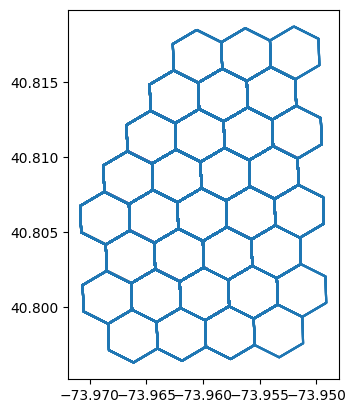

In [61]:
mh_net_nodes.boundary.plot()

In [62]:
# mh_net_edges.to_crs("EPSG:2263", inplace=True)
# mh_net_nodes.to_crs("EPSG:2263", inplace=True)

In [63]:
mh_net_nodes

,y,x,highway,street_count,geometry,h3
osmid,,,,,,
42421737,40.799244,-73.962873,traffic_signals,4,"POLYGON ((-73.96198 40.79993, -73.96409 40.798...",892a10088b3ffff
42421741,40.800429,-73.965691,traffic_signals,4,"POLYGON ((-73.96422 40.80251, -73.96633 40.801...",892a1008887ffff
42421745,40.801398,-73.967996,traffic_signals,4,"POLYGON ((-73.96850 40.80240, -73.97061 40.801...",892a100888fffff
42421852,40.812622,-73.956823,traffic_signals,3,"POLYGON ((-73.95607 40.81332, -73.95818 40.812...",892a1008c33ffff
42421857,40.813822,-73.959800,traffic_signals,4,"POLYGON ((-73.95831 40.81590, -73.96042 40.814...",892a1008c07ffff
...,...,...,...,...,...,...
12818423593,40.800498,-73.957996,NaN,3,"POLYGON ((-73.95994 40.80263, -73.96205 40.801...",892a1008d4bffff
12818423594,40.800489,-73.958346,NaN,3,"POLYGON ((-73.95994 40.80263, -73.96205 40.801...",892a1008d4bffff
12818423614,40.800753,-73.958172,NaN,3,"POLYGON ((-73.95994 40.80263, -73.96205 40.801...",892a1008d4bffff


In [64]:
mh_net_nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [65]:
mh_net_nodes_copy = mh_net_nodes.copy()

In [66]:
mh_net_nodes_copy.drop_duplicates(subset=["h3"], inplace=True)

In [67]:
mh_net_nodes_copy.shape

(32, 6)

<Axes: >

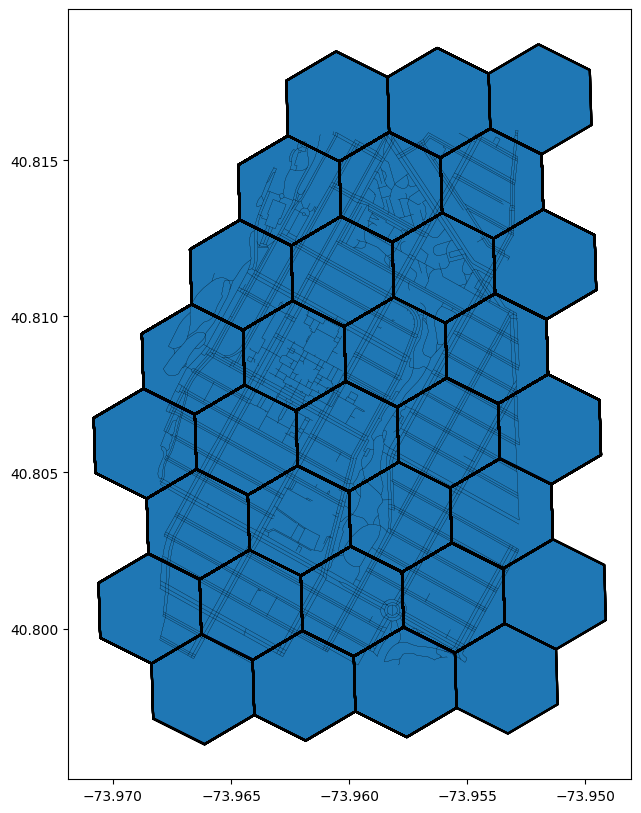

In [68]:
ax = mh_net_nodes_copy.plot(figsize=(10, 10))
mh_net_nodes.boundary.plot(ax=ax, color="black")
mh_net_edges.plot(
    ax=ax,
    color="black",
    linewidth=0.1,
)  # .set_axis_off()

In [69]:
from lonboard import Map, PolygonLayer

In [70]:
layer = PolygonLayer.from_geopandas(
    mh_net_nodes[["geometry"]],
    get_line_color="black",
    get_fill_color="none",
    get_line_width=3,
)
# edges_layer = LineLayer.from_geopandas(
#     mh_net_edges[["geometry"]],
#     get_line_color="black",
#     get_fill_color="none",
#     get_line_width=1,
# )
m = Map(
    [
        layer,
    ]
)
m

Map(layers=[PolygonLayer(get_fill_color=(0, 0, 0, 0), get_line_color=(0, 0, 0, 255), get_line_width=3.0, table…

In [71]:
mh_net_nodes_copy.drop_duplicates(subset="h3", inplace=True)

In [72]:
# create an adjacency matrix for the hexagons
w = lps.weights.Queen.from_dataframe(mh_net_nodes_copy)

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_65798/2291160329.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = lps.weights.Queen.from_dataframe(mh_net_nodes_copy)


In [73]:
w

In [74]:
# get neighbors for each hexagon
neighbors = {k: v for k, v in w.neighbors.items()}

In [75]:
neighbors

{0: [1, 18, 17, 23],
 1: [0, 2, 18, 6, 23, 12],
 2: [1, 6, 23],
 3: [16, 4, 21, 22, 8, 11],
 4: [3, 5, 22, 8, 25, 28],
 5: [8, 25, 26, 4],
 6: [1, 2, 7, 12, 13],
 7: [19, 6, 27, 12, 13, 30],
 8: [3, 4, 5, 26, 11, 30],
 9: [16, 10, 20],
 10: [16, 19, 20, 9, 11, 15],
 11: [16, 3, 19, 8, 10, 30],
 12: [1, 18, 19, 6, 7, 15],
 13: [27, 6, 7],
 14: [17, 18, 20, 31, 29, 15],
 15: [18, 19, 20, 10, 12, 14],
 16: [3, 21, 9, 10, 11],
 17: [0, 18, 29, 14],
 18: [0, 1, 17, 12, 14, 15],
 19: [7, 10, 11, 12, 30, 15],
 20: [9, 10, 31, 14, 15],
 21: [16, 3, 22],
 22: [3, 4, 21, 24, 28],
 23: [0, 1, 2],
 24: [28, 22],
 25: [28, 4, 5],
 26: [8, 27, 5, 30],
 27: [26, 13, 30, 7],
 28: [24, 25, 4, 22],
 29: [17, 14, 31],
 30: [19, 7, 8, 27, 26, 11],
 31: [20, 29, 14]}

In [76]:
# create networkx graph from adjacency matrix
G = nx.Graph(neighbors)

In [77]:
# get the path between two nodes
path = nx.shortest_path(G, 22, 23)

In [78]:
path

[22, 3, 11, 19, 12, 1, 23]

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_65798/4092262763.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes_copy.geometry.centroid.x,
/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_65798/4092262763.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mh_net_nodes_copy.geometry.centroid.y,


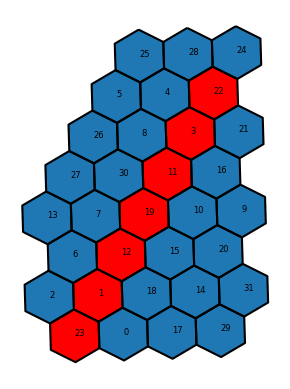

In [79]:
# plot the path
ax = mh_net_nodes_copy.plot()
mh_net_nodes_copy.boundary.plot(ax=ax, color="black")
mh_net_nodes_copy.iloc[path].plot(ax=ax, color="red").set_axis_off()

# label cells with their index
for x, y, label in zip(
    mh_net_nodes_copy.geometry.centroid.x,
    mh_net_nodes_copy.geometry.centroid.y,
    neighbors.keys(),
):
    ax.text(x, y, label, fontsize=6)